BLOQUE DE DECLARACIÓN DE FUNCIONES

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.io import wavfile
from scipy import signal
from scipy.stats import linregress

frecuencias = np.array([100, 125, 160, 200, 250, 315, 400, 500, 630, 800, 1000, 1250, 1600, 2000, 2500, 3150])
ref_curve_base = np.array([
        33, 36, 39, 42, 45, 48, 51, 52, 53, 
        54, 55, 56, 56, 56, 56, 56
    ])

def leer_rango_excel_a_array(ruta_archivo, hoja_nombre=0, columnas_a_leer="", filas_a_leer=1, filas_a_saltar=1):
    """
    Abre un archivo Excel y extrae un rango de celdas específico
    (D3 a BO42) y lo guarda en un array (lista de listas).
"""
    print(f"Intentando leer el archivo: {ruta_archivo}...")

    try:
        # 1. Filas:
        # Queremos empezar en la Fila 3.
        # Las filas en pandas se indexan desde 0.
        # Fila 1 = índice 0, Fila 2 = índice 1, Fila 3 = índice 2.
        # Así que saltamos las 2 primeras filas.
        filas_a_saltar = filas_a_saltar


        #filas_a_leer = 40
        # Queremos leer desde la fila 3 hasta la 42 (inclusive).
        # Número de filas = 42 - 3 + 1 = 40 filas.

        # --- Lectura del archivo ---

        # Usamos 'header=None' porque el rango (D3) no es un encabezado,
        # es el inicio de los datos.
        df_rango = pd.read_excel(
            ruta_archivo,
            sheet_name= hoja_nombre, #Segunda hoja, Espectro Total
            header=None,             # Trata la primera fila leída (Fila 3) como datos
            skiprows=filas_a_saltar, # Salta las 2 primeras filas
            usecols=columnas_a_leer, # Lee solo el rango de columnas D-BO
            nrows=filas_a_leer       # Lee exactamente 40 filas
        )

        # Convertir el DataFrame de pandas a un array (lista de listas)
        # .values obtiene los datos como un array de NumPy
        # .tolist() lo convierte a una lista estándar de Python
        array_valores = df_rango.values.tolist()

        # Verificación
        if array_valores:
            num_filas = len(array_valores)
            num_cols = len(array_valores[0]) # Longitud de la primera fila
            print(f"Éxito: Se leyó un array de {num_filas} filas x {num_cols} columnas.")
        else:
            print("Advertencia: El rango D3:BO42 parece estar vacío.")

        return array_valores

    except FileNotFoundError:
        print(f"Error: No se pudo encontrar el archivo en la ruta: '{ruta_archivo}'.")
        return None
    except Exception as e:
        print(f"Ocurrió un error inesperado al leer el rango: {e}")
        return None
        
def separar_filas_en_cinco(datos_array):
    #Esta función leerá el array con las 20 medidas y devolverá cuatro grupos de 5: 
    # L2F1, L1F1, L1F2, L2F2
    datos_array = np.array(datos_array)
    if datos_array.shape[0] != 20:
         raise ValueError(f"El array de entrada debe contener exactamente 20 elementos, pero tiene {datos_array.size}.")

    # La división se realiza asumiendo el orden secuencial de los 20 elementos
    # en el array de entrada:
    # Grupo 1 (Elementos 0-4): L2F1
    L2F1 = datos_array[0:5]
    
    # Grupo 2 (Elementos 5-9): L1F1
    L1F1 = datos_array[5:10]
    
    # Grupo 3 (Elementos 10-14): L1F2
    L1F2 = datos_array[10:15]
    
    # Grupo 4 (Elementos 15-19): L2F2
    L2F2 = datos_array[15:20]
    
    return L2F1, L1F1, L1F2, L2F2

def promediado_energetico(datos_array):

    promedio = np.round(10 * np.log10((1 / len(datos_array)) * np.sum(10**(0.1 * datos_array), axis = 0)), 1)

    return promedio

def crear_filtro_pasobanda(f_baja,f_alta,fs,orden=4):
    nyq = 0.5 * fs
    low = f_baja / nyq
    high = f_alta / nyq

    # Usamos salida sos para mejorar estabilidad
    filtro_banda = signal.butter(orden, [low, high], btype='band',output='sos')
    return filtro_banda

def  integracion_schroeder(respuesta_impulso):
    """
    Integral de Schroeder
    """
    energia = respuesta_impulso**2
    #suma acumulativa inversa de la energía desde el final hasta el inicio
    schroeder = np.cumsum(energia[::-1])[::-1]
    # Esto asegura que la curva empiece en 0 dB.
    val_max = np.max(schroeder)
    if val_max == 0:
        val_max = 1e-10 # Evitar división por cero
    energia_normalizada = schroeder / val_max
    schroeder_db = 10 * np.log10(energia_normalizada + 1e-10)  # Sumo 1e-10 para que no falle el log
    return schroeder_db

def calcular_t60(curva, fs, tipo='T20'):
    """
    Calcula el T60 usando regresión lineal
    """
    
    if tipo == 'T20':
        lim_sup, lim_inf = -5, -25
    elif tipo == 'T30':
        lim_sup, lim_inf = -5, -35
    else:
        return 0

    t = np.arange(len(curva)) / fs  # Tiempo en segundos

    # Buscar índices donde la curva cruza los límites
    try:
        idx_inicio = np.argmax(curva <= lim_sup)
        idx_fin = np.argmax(curva <= lim_inf)
    except:
        return 0 #Si no se encuentra el rango

    if idx_fin <= idx_inicio:
        return 0  # Si no hay un rango válido

    # Extraer los segmentos relevantes
    y_segmento = curva[idx_inicio:idx_fin]
    t_segmento = t[idx_inicio:idx_fin]

    # Realizar regresión lineal(mínimos cuadrados)
    #pendiente(m), ordenada(b),correlación(r)
    pendiente,ordenada,r_value, p_value, std_err = linregress(t_segmento, y_segmento)
    if abs(r_value) < 0.95:
        return 0 #Si la correlación es baja, no se considera válida
    t60 = -60 / pendiente

    return t60

def calcular_dnw(dn_medido, step):
    # --- 1. DATOS FIJOS ---
    frecuencias = np.array([
        100, 125, 160, 200, 250, 315, 400, 500, 630, 
        800, 1000, 1250, 1600, 2000, 2500, 3150
    ])

    # --- 2. CÁLCULO (Algoritmo ISO 717-1) ---
    dnw_final = 0
    ref_final = np.zeros(len(frecuencias))
    suma_desv_final = 0
    
    desplazamientos = np.arange(60.0, -60.0, step)
    
    for desplazamiento in desplazamientos:
    # Desplazamos la curva desde arriba hacia abajo
        ref_desplazada = ref_curve_base + desplazamiento
        diferencias = ref_desplazada - dn_medido
        
        # Solo sumamos si la referencia pide más de lo que da la puerta (Ref > Medido)
        desviaciones = diferencias[diferencias > 0]
        suma = np.sum(desviaciones)
        if suma <= 32.0:
            dnw_final = 52 + desplazamiento # 52 es el valor de ref a 500Hz
            ref_final = ref_desplazada
            suma_desv_final = suma
            break # Ya lo tenemos, paramos el bucle
    
    return dnw_final, desplazamiento, ref_final


def montecarlo_dnw(L1, L2, A, u_L1, u_L2, u_A, n_sims=1):
    try:
        L1, L2, A = np.array(L1).reshape(-1), np.array(L2).reshape(-1), np.array(A).reshape(-1)
        u_L1, u_L2, u_A = np.array(u_L1).reshape(-1), np.array(u_L2).reshape(-1), np.array(u_A).reshape(-1)
    except Exception as e:
        print(f"Error en datos de entrada: {e}")
        return np.array([])

    if not all(len(x) == 16 for x in [L1, L2, A, u_L1, u_L2, u_A]):
        raise ValueError("Todos los vectores deben tener longitud 16.")

    # Generación vectorial de ruido
    r_L1 = np.random.normal(0, u_L1, (n_sims, 16))
    r_L2 = np.random.normal(0, u_L2, (n_sims, 16))
    r_A  = np.random.normal(0, u_A, (n_sims, 16))

    # Simulación física
    sim_L1 = L1 + r_L1
    sim_L2 = L2 + r_L2
    sim_A  = np.maximum(A + r_A, 0.1) # Evita log(<=0)

    sim_Dn = sim_L1 - sim_L2 - 10 * np.log10(sim_A / 10)
    sim_Dnw = np.array([calcular_dnw(fila, step = -0.1)[0] for fila in sim_Dn])    # Cálculo iterativo de Dnw
    return sim_Dnw

def grafica_estandar(datos, titulo):

    fig, ax = plt.subplots(figsize=(10, 6))
    x_indices = np.arange(len(frecuencias))

    ax.plot(x_indices, datos, color='black', marker='o', markersize=5, linewidth=1.5)
    ax.set_aspect(0.4)

    ax.set_xticks(x_indices)
    ax.set_xticklabels([str(f) for f in frecuencias], rotation=45, fontsize=9)

    y_min = 10
    y_max = int(np.ceil((np.max(datos) + 10) / 10) * 10)
    ax.set_ylim(y_min, y_max)
    ax.set_yticks(np.arange(y_min, y_max + 1, 10))

    ax.grid(True, which='major', axis='y', color='black', linestyle='-', linewidth=0.8, alpha=0.3)
    ax.grid(True, which='major', axis='x', color='black', linestyle='-', linewidth=0.5, alpha=0.2)

    ax.set_xlabel('Frecuencia (Hz)')
    ax.set_ylabel("")
    ax.set_title(titulo)

    plt.tight_layout()
    plt.show()

APERTURA DE ARCHIVOS DE MEDIDAS Y PROMEDIADO DE L1 Y L2 PARA CADA FUENTE

In [56]:
nombre_archivo = "P4_G7_Datos.xlsx"

medidas_banda_ancha = leer_rango_excel_a_array(nombre_archivo, "Banda Ancha Total", "U" , 23, 3) #LECTURA DE LAEQ -- filas_a_saltar = 3  # (Saltamos Fila 1 :texto Fila 2 : calibracion y Fila 3: INVALIDA)
medidas_espectro = leer_rango_excel_a_array(nombre_archivo, "Espectro Total", "EK:EZ" , 23, 3) #LECTURA LZEQ EN ESPECTRO 100 HZ A 3150 HZ -- filas_a_saltar = 3  # (Saltamos Fila 1 :texto Fila 2 : calibracion y Fila 3: INVALIDA)

#LIMPIAR MATRICES: SEPARAR EN RUIDO DE FONDO Y MEDIDAS, Y POR RECINTO Y FUENTE

ruido_banda_ancha = np.array(medidas_banda_ancha[:3])
Laeq_banda_ancha = np.array(medidas_banda_ancha[3:]) # QUITAR LAS TRES PRIMERAS POSICIONES QUE SON DE RUIDO DE FONDO

ruido_espectro = np.array(medidas_espectro[:3])
Lzeq_espectro = np.array(medidas_espectro[3:]) # QUITAR LAS TRES PRIMERAS POSICIONES QUE SON DE RUIDO DE FONDO

#print(Lzeq_espectro.shape) debe dar 20 medidas x 16 bandas de frecuencia

L2F1, L1F1, L1F2, L2F2 = separar_filas_en_cinco(Lzeq_espectro)

L2F1_BA, L1F1_BA, L1F2_BA, L2F2_BA = separar_filas_en_cinco(Laeq_banda_ancha)

F1_emisor = promediado_energetico(L1F1)
F2_emisor = promediado_energetico(L1F2)
F1_receptor = promediado_energetico(L2F1)
F2_receptor = promediado_energetico(L2F2)

#ESTOS ARRAYS CONTIENEN LOS NIVELES Lzeq DEL ESPECTRO ENTRE 100 Y 3150 HZ EN CADA RECINTO Y POSICIÓN DE FUENTE

L1_promed = np.round(10 * np.log10((1 / 2) *((10**(0.1 * F1_emisor) + 10**(0.1 * F2_emisor)))), 1)
L2_promed = np.round(10 * np.log10((1 / 2) *((10**(0.1 * F1_receptor) + 10**(0.1 * F2_receptor)))), 1)
ruido_promed = np.round(10 * np.log10((1 / len(ruido_espectro)) * np.sum(10**(0.1 * ruido_espectro), axis = 0)), 1)


Intentando leer el archivo: P4_G7_Datos.xlsx...


/home/elias/Documents/RUIDO/P4/.venv/lib/python3.14/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Éxito: Se leyó un array de 23 filas x 1 columnas.
Intentando leer el archivo: P4_G7_Datos.xlsx...
Éxito: Se leyó un array de 23 filas x 16 columnas.


/home/elias/Documents/RUIDO/P4/.venv/lib/python3.14/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


COMPROBACIÓN PREGUNTA TEÓRICA 2

CUMPLE 1: DIFERENCIAS < 6DB ENTRE BANDAS


<Figure size 1000x600 with 0 Axes>

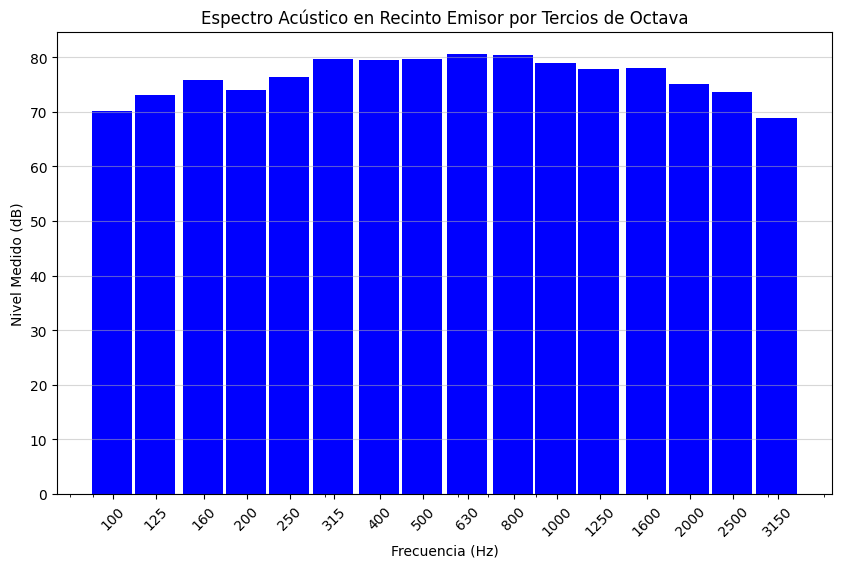

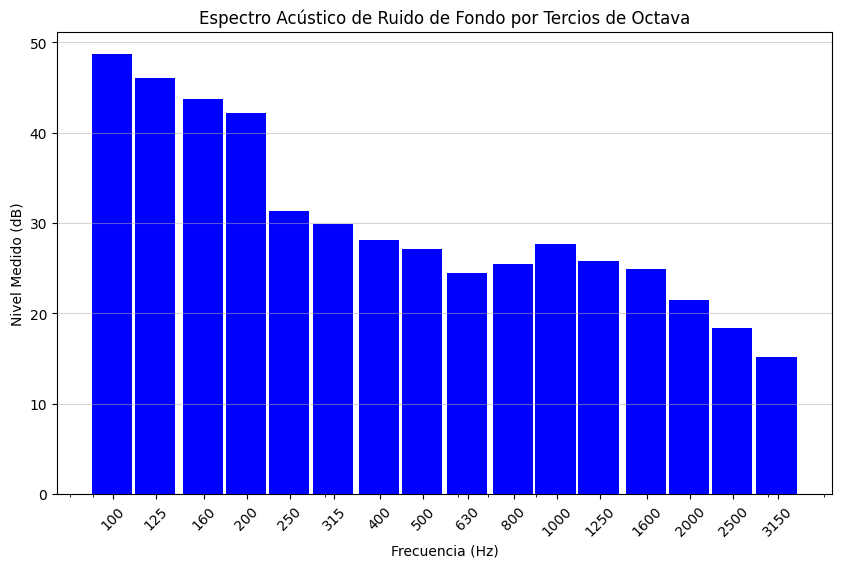

CUMPLE 2: DIFERENCIAS > 10 DB ENTRE MEDIDA Y RUIDO DE FONDO EN CADA BANDA. NO SE APLICAN CORRECCIONES POR RUIDO DE FONDO


In [57]:
plt.figure(figsize=(10, 6)) # Define el tamaño de la figura (ancho, alto)
eje_x = np.array([
    100, 125, 160, 200, 250, 315, 400, 500, 630, 
    800, 1000, 1250, 1600, 2000, 2500, 3150
])

plt.figure(figsize=(10, 6)) 

# Cálculo del ancho de barra para escala logarítmica
ancho_barra_log = eje_x * (2**(1/6) - 2**(-1/6)) * 0.9

# Gráfico de barras
plt.bar(eje_x, L1_promed, width=ancho_barra_log, color='blue') 

# Escala y etiquetas esenciales
plt.xscale('log')
plt.xticks(eje_x, labels=[f'{int(f)}' for f in eje_x], rotation=45) 

plt.title('Espectro Acústico en Recinto Emisor por Tercios de Octava')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Nivel Medido (dB)')
plt.grid(True, axis='y', alpha=0.5)

diferencias_absolutas = np.abs(np.diff(L1_promed))
limite_cumplido = diferencias_absolutas <= 6

if limite_cumplido.all:
    print("CUMPLE 1: DIFERENCIAS < 6DB ENTRE BANDAS")
else:
    print("NO CUMPLE 2: DIFERENCIAS > 6DB ENTRE BANDAS")

#CONDICIÓN 2:
plt.figure(figsize=(10, 6)) 

# Cálculo del ancho de barra para escala logarítmica

# Gráfico de barras
plt.bar(eje_x, ruido_promed, width=ancho_barra_log, color='blue') 

# Escala y etiquetas esenciales
plt.xscale('log')
plt.xticks(eje_x, labels=[f'{int(f)}' for f in eje_x], rotation=45) 

plt.title('Espectro Acústico de Ruido de Fondo por Tercios de Octava')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Nivel Medido (dB)')
plt.grid(True, axis='y', alpha=0.5)

plt.show()

diferencias_absolutas = np.abs(L1_promed - ruido_promed)
limite_cumplido = diferencias_absolutas > 10

if limite_cumplido.all():
    print("CUMPLE 2: DIFERENCIAS > 10 DB ENTRE MEDIDA Y RUIDO DE FONDO EN CADA BANDA. NO SE APLICAN CORRECCIONES POR RUIDO DE FONDO")
else:
    print("NO CUMPLE 2: DIFERENCIAS < 10 DB ENTRE MEDIDA Y RUIDO DE FONDO EN CADA BANDA")


APERTURA DE ARCHIVOS DE MEDIDAS Y PROMEDIADO DE TIEMPO DE REVERBERACIÓN

Intentando leer el archivo: P4_G7_TR.xlsx...
Éxito: Se leyó un array de 12 filas x 16 columnas.


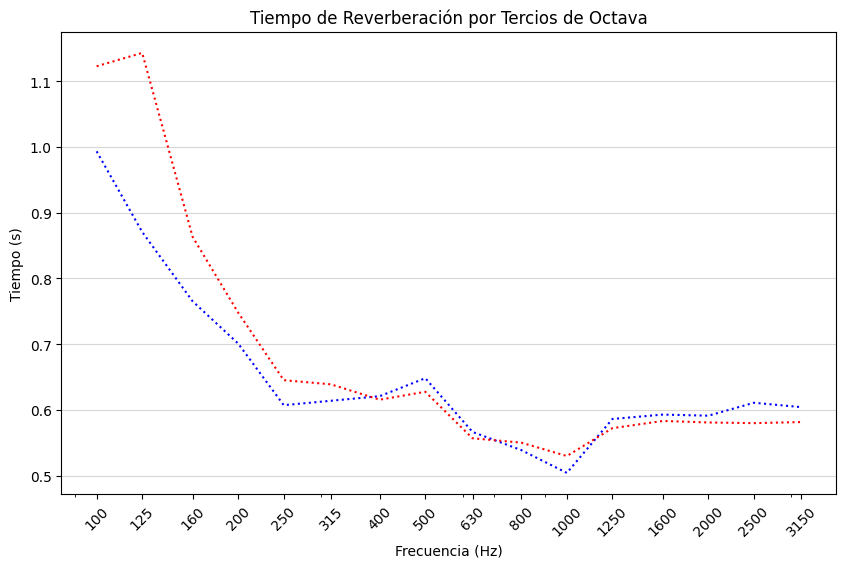

In [58]:
nombre_archivo = "P4_G7_TR.xlsx"

# arrays de 12 filas (3xT20 + 3xT30 + 3xT20cc + 3xT30cc) x 27 columnas
tr_todos = leer_rango_excel_a_array(nombre_archivo, "tr_organizado", "J:Y" , 13, 1) #LECTURA DE TODOS LOS TR (100 a 3150 Hz)-- filas_a_saltar = 1 # fc por banda
tr_todos = np.array(tr_todos)
# print(tr_todos)

# PROMEDIADO DEL TIEMPO DE REVERBERACIÓN PARA CADA BANDA
t20_promed = tr_todos[0:3,:].mean(axis=0)  # array 1 fila x 27 columnas
t30_promed = tr_todos[3:6,:].mean(axis=0) # array 1 fila x 27 columnas

# print(t20_promed)
# print(t30_promed)
# print(np.size(t20_promed))

# Gráfica del tiempo de reverberación vs frecuencia
plt.figure(figsize=(10, 6))

# Gráfico de línea
plt.plot(eje_x, t20_promed, color='blue',linestyle='dotted', label='T20')
plt.plot(eje_x, t30_promed, color='red',linestyle='dotted', label='T30')

# Escala y etiquetas esenciales
plt.xscale('log')
plt.xticks(eje_x, labels=[f'{int(f)}' for f in eje_x], rotation=45)

plt.title('Tiempo de Reverberación por Tercios de Octava')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Tiempo (s)')
plt.grid(True, axis='y', alpha=0.5)

plt.show()

CÁLCULO DE ÍNDICES: DN, DNT, R y DNW

In [59]:
# Aproximación del tiempo de reverberación (Usando T20 o T30)
T_reverb_promed = t20_promed

# Supercies, áreas y volúmenes
A0 = 10 #[m^2] -- Área de absorción de referencia (UNE-EN ISO 140-4:1999)
T0 = 0.5 #[s] -- tiempo de reverberación de referencia para habitaciones amuebladas (vivienda), es equivalente a estandarizar respecto a A0=0.32*V_receptor (Norma UNE-EN ISO 140-4:1999 Apartado 3.4)
V_receptor = 40.15 * 3.3 #[m^3] -- Volúmen del recinto receptor
A = 0.16 * V_receptor / T_reverb_promed #[m^2] -- Área de absorción del recinto receptor (Formula de Sabine - Norma ISO 354)
S = (5.2 + 2.2) * 3.3 #[m^2] -- área del elemento separador

# Diferencia de niveles Dx y R'
Dn = L1_promed - L2_promed - 10*np.log10(A/A0) # Diferencia de niveles normalizada

# To-Do: ¿Qué estandarización usamos?
DnT_1 = L1_promed - L2_promed + 10*np.log10(T_reverb_promed/T0) # Diferencia de niveles estandarizada
# DnT_2 = L1_promed - L2_promed + 10*np.log10(A/(0.32*V_receptor))
# print((DnT_1 - DnT_2))

R_prima = L1_promed - L2_promed + 10*np.log10(S/A) # Índice de reducción sonora aparente

[15.6 17.8 18.  18.4 19.7 22.9 22.  22.6 22.4 20.1 19.4 21.9 22.2 24.
 27.2 26.6]


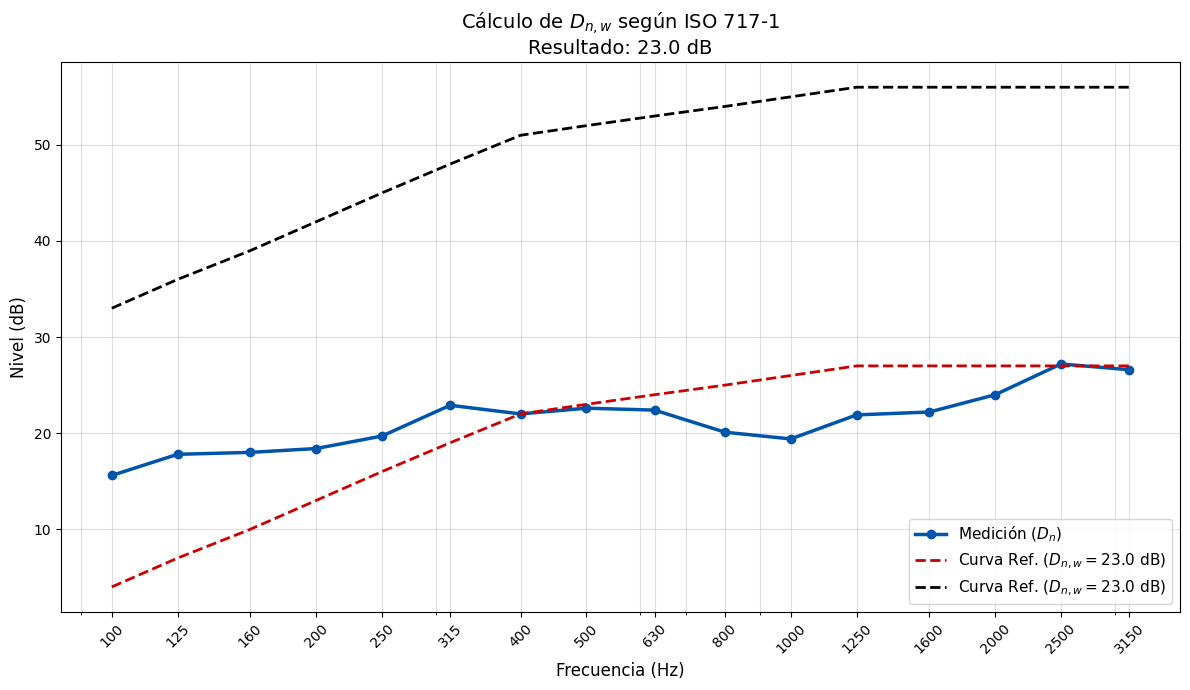

RESULTADO FINAL:
El valor Dn,w calculado es: 23.0 dB
(C;Ctr): -1.0 -2.0


In [60]:
#INDICE GLOBAL DNW
Dn_round=np.round(Dn,1)

dnw_resultado, desplazamiento, ref_final = calcular_dnw(Dn_round, step = -1)

print(Dn_round)

fig, ax = plt.subplots(figsize=(12, 7))
    
    #Curva Medida
ax.plot(frecuencias, Dn_round, color='#0055AA', marker='o', 
            linewidth=2.5, label='Medición ($D_n$)')
    
    #Curva de Referencia Desplazada (Resultado Dn,w)
ax.plot(frecuencias, ref_final, color='#CC0000', linestyle='--', 
            linewidth=2, label=f'Curva Ref. ($D_{{n,w}} = {dnw_resultado}$ dB)')
      #Curva de Referencia
ax.plot(frecuencias, ref_curve_base, color='black', linestyle='--', 
            linewidth=2, label=f'Curva Ref. ($D_{{n,w}} = {dnw_resultado}$ dB)')
    
ax.set_title(f'Cálculo de $D_{{n,w}}$ según ISO 717-1\nResultado: {dnw_resultado} dB', fontsize=14)
ax.set_xlabel('Frecuencia (Hz)', fontsize=12)
ax.set_ylabel('Nivel (dB)', fontsize=12)
    
    # Eje Logarítmico y Ticks exactos
ax.set_xscale('log')
ax.set_xticks(frecuencias)
ax.set_xticklabels([str(int(f)) for f in frecuencias], rotation=45)
    
ax.grid(True, which="both", ls="-", alpha=0.4)
ax.legend(loc='lower right', fontsize=11)
    
plt.tight_layout()
plt.show()

print(f"RESULTADO FINAL:")
print(f"El valor Dn,w calculado es: {dnw_resultado} dB")

#AHORA CALCULAMOS LOS TERMINOS DE ADAPTACIÓN ESPECTRAL
espectro_1 = np.array([
    -29, -26, -23,  # 100-160 Hz
    -21, -19, -17,  # 200-315 Hz
    -15, -13, -12,  # 400-630 Hz
    -11, -10,  -9,  # 800-1250 Hz
     -9,  -9,  -9,  # 1600-2500 Hz
     -9             # 3150 Hz
])
espectro_2 = np.array([
    -21, -20, -18,  # 100-160 Hz (Fíjate que aquí los niveles son mucho más altos que en el 1)
    -16, -15, -14,  # 200-315 Hz
    -13, -12, -11,  # 400-630 Hz
     -9,  -8,  -9,  # 800-1250 Hz
    -10, -11, -13,  # 1600-2500 Hz
    -15             # 3150 Hz
])

Xa1 = -10 * np.log10(np.sum(10**(0.1*(espectro_1-Dn_round))))
Xa2 = -10 * np.log10(np.sum(10**(0.1*(espectro_2-Dn_round))))

C = np.round(np.round(Xa1,1) - dnw_resultado,0)
Ctr = np.round(np.round(Xa2,1) - dnw_resultado,0)

print ("(C;Ctr):", C, Ctr)

GRÁFICAS DE LOS INDICES (Formato ANEXO E)

/tmp/ipykernel_136832/1575361483.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


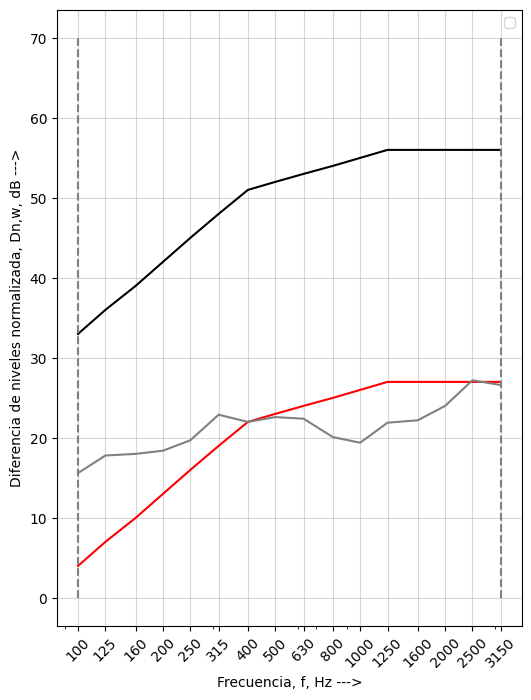

In [66]:
# Gráfica del Dn,dB vs frecuencia
plt.figure(figsize=(6, 8))
ref_curve_base = np.array([
        33, 36, 39, 42, 45, 48, 51, 52, 53, 
        54, 55, 56, 56, 56, 56, 56
    ])
plt.plot(
    eje_x,
    ref_curve_base + desplazamiento,
    color='red',
    label=''
)
plt.plot(
    eje_x,
    ref_curve_base,
    color='black',
    label=''
)
plt.plot(
    eje_x,
    Dn_round,
    color='grey',
    label=''
)

plt.vlines(
    [100, 3150], 0, 70,
    linestyle='--',
    color='gray')

# Escala y etiquetas esenciales
plt.xscale('log')
plt.xticks(eje_x, labels=[f'{int(f)}' for f in eje_x], rotation=45)

plt.xlabel('Frecuencia, f, Hz --->')
plt.ylabel('Diferencia de niveles normalizada, Dn,w, dB --->')
plt.grid(True, axis='both', alpha=0.5) # cuadricula

# Leyenda
plt.legend()

plt.show()



CÁLCULO DE INCERTIDUMBRE MONTECARLO PARA DNW

In [ ]:
u_L1 = np.array([
    0.7216770592, 0.7070124940, 0.4878656464, 0.5726547341, 
    1.0110065940, 0.6371506886, 0.7433369955, 0.6982731875, 
    0.8063801833, 0.7363565712, 0.6279646133, 0.5790633241, 
    0.5263759746, 0.5112364098, 0.5661860707, 0.6262583776
])

u_L2 = np.array([
    0.9306819483, 0.9801440370, 0.7211752754, 0.7560047766, 
    0.6948377908, 0.8223900805, 0.6110831913, 0.5489043633, 
    0.6834634023, 0.4755931968, 0.6244009574, 0.5702490684, 
    0.5922184282, 0.4376031942, 0.5933730324, 0.4890562340
])

u_A = np.array([
    1.0255779970, 1.5873419930, 1.3642336750, 0.8680078790, 
    1.3680220110, 2.3434744140, 1.0660384440, 1.4112964540, 
    0.2145482274, 1.0518412170, 0.4716588392, 0.4172447616, 
    1.2052290860, 0.7966013804, 0.1807857585, 0.2322595584
])

# 2. Ejecutar Simulación
resultados = montecarlo_dnw(L1_promed, L2_promed, A, u_L1, u_L2, u_A, 100)
# 3. Análisis Estadístico
media_dnw = np.mean(resultados)
desv_std_dnw = np.std(resultados)

U_Dnw = np.round(desv_std_dnw * 2,1)

print(np.round(media_dnw,1))
print("Incertidumbre de Dnw mediante Montecarlo" , U_Dnw)


Incertidumbre de Dnw mediante Montecarlo 0.6


CÁLCULO DEL TIEMPO DE REVERBERACIÓN

Archivo 'P1.wav' cargado correctamente. Frecuencia de muestreo: 44100 Hz, Duración: 5.94 s
Frec (Hz)  | T20 (s)    | T30 (s)   
100        | 0.958      | 1.435     
125        | 0.654      | ---       
160        | 0.820      | 1.043     
200        | 0.756      | 0.882     
250        | 0.613      | ---       
315        | 0.562      | ---       
400        | 0.710      | 0.952     
500        | 0.564      | 0.717     
630        | 0.568      | 0.613     
800        | 0.535      | 0.686     
1000       | 0.485      | 0.609     
1250       | 0.613      | ---       
1600       | 0.615      | ---       
2000       | 0.591      | 0.665     
2500       | 0.591      | 0.664     
3150       | 0.602      | 0.698     
4000       | 0.589      | ---       


/tmp/ipykernel_136832/1142267062.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, datos_audio = wavfile.read(nombre_archivo)


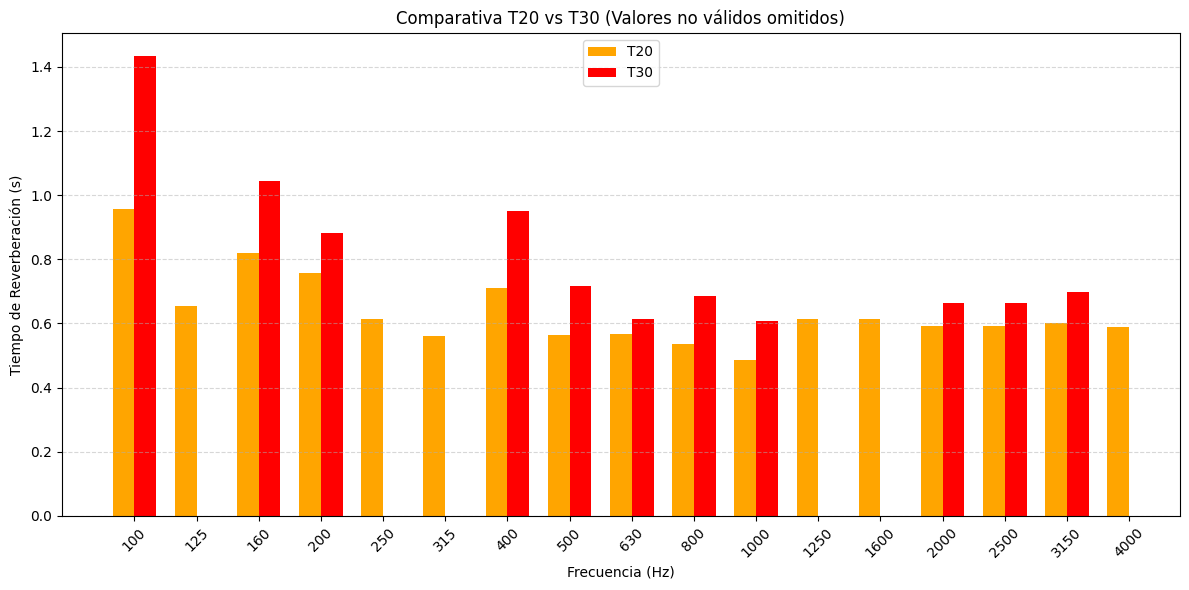

In [63]:
nombre_archivo = 'P1.wav'
frecuencias_centrales = [100,125,160,200,250,315,400,500,630,800,1000,1250,1600,2000,2500,3150,4000]

#Cargar audio
try:
    fs, datos_audio = wavfile.read(nombre_archivo)
    print(f"Archivo '{nombre_archivo}' cargado correctamente. Frecuencia de muestreo: {fs} Hz, Duración: {len(datos_audio)/fs:.2f} s")
except Exception as e:
    print(f"Error al cargar el archivo '{nombre_archivo}': {e}")

#listas para guardar resultados
valores_t20 = []
valores_t30 = []

if len(datos_audio) > 0:
    
    print(f"{'Frec (Hz)':<10} | {'T20 (s)':<10} | {'T30 (s)':<10}")
    

    for fc in frecuencias_centrales:
        #Definir banda
        f_inf = fc * (2 ** (-1/6))
        f_sup = fc * (2 ** (1/6))
        
        #Filtrar
        sos = crear_filtro_pasobanda(f_inf, f_sup, fs)
        señal_filtrada = signal.sosfilt(sos, datos_audio)
        
        # Integración
        curva = integracion_schroeder(señal_filtrada)
        
        # calcular T20 y T30
        res_t20 = calcular_t60(curva, fs, tipo='T20')
        res_t30 = calcular_t60(curva, fs, tipo='T30')
        
        valores_t20.append(res_t20)
        valores_t30.append(res_t30)
        
        # Si es 0, mostramos un guion "-"
        str_t20 = f"{res_t20:.3f}" if res_t20 > 0 else "---"
        str_t30 = f"{res_t30:.3f}" if res_t30 > 0 else "---"
        
        print(f"{fc:<10} | {str_t20:<10} | {str_t30:<10}")

    
    # Gráfica comparativa T20 y T30
    plt.figure(figsize=(12, 6))
    x = np.arange(len(frecuencias_centrales))
    ancho = 0.35

    v_t20_plot = np.array(valores_t20, dtype=float)
    v_t20_plot[v_t20_plot == 0] = np.nan
    
    v_t30_plot = np.array(valores_t30, dtype=float)
    v_t30_plot[v_t30_plot == 0] = np.nan

    plt.bar(x - ancho/2, v_t20_plot, ancho, label='T20', color='orange')
    plt.bar(x + ancho/2, v_t30_plot, ancho, label='T30', color='red')
    
    plt.xticks(x, frecuencias_centrales, rotation=45)
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Tiempo de Reverberación (s)')
    plt.title('Comparativa T20 vs T30 (Valores no válidos omitidos)')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


GENERACIÓN DE GRÁFICAS ESTANDARIZADAS

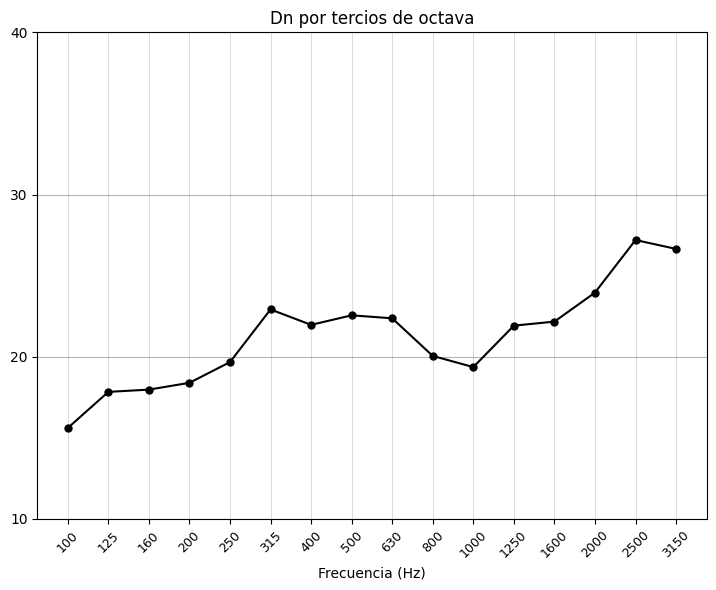

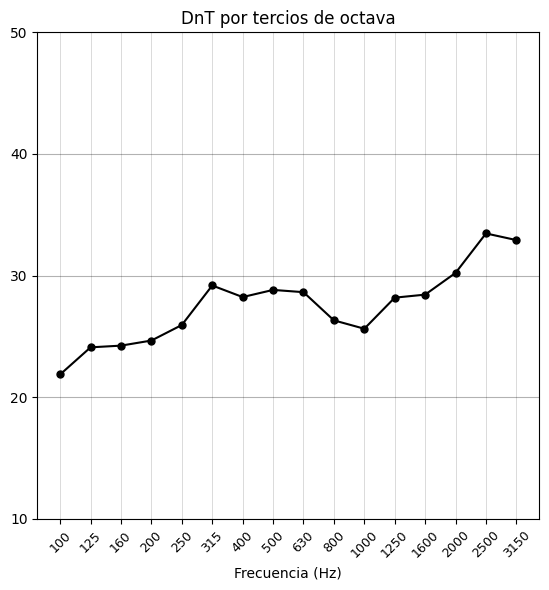

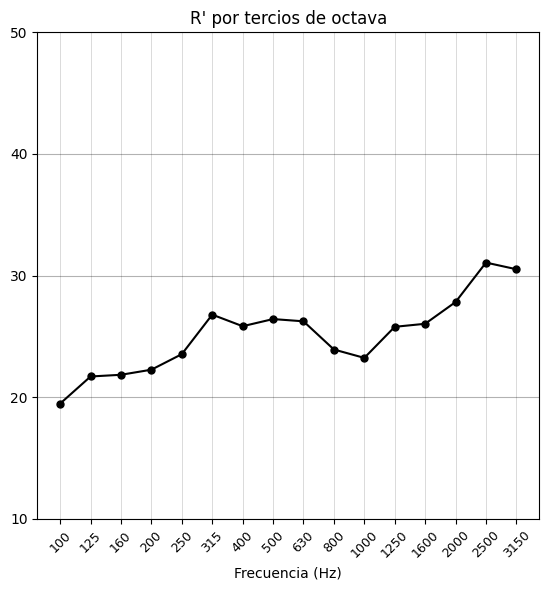

In [64]:
grafica_estandar(Dn, "Dn por tercios de octava")
grafica_estandar(DnT_1, "DnT por tercios de octava")
grafica_estandar(R_prima, "R' por tercios de octava")